In [ ]:
# All torch imports needed
import torch.nn as nn
from torchvision.models import vgg16
from torchsummary import summary
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import time
from threading import current_thread
import torch.nn.functional as F
from torchvision import transforms
from torchvision.datasets import ImageFolder
import cv2


In [ ]:
import numpy as np
data = np.load('/content/drive/MyDrive/Dissertation Dataset/plant_disease_data.npz')
X = data['images']
y = data['labels']

print("Data Loaded Successfully")
print("Images Shape: ", X.shape)
print("Labels Shape: ", y.shape)

Data Loaded Successfully
Images Shape:  (20638, 256, 256, 3)
Labels Shape:  (20638,)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
# Get the training and testing images ready:
# Define split ratios
train_ratio = 0.7  # 70% for training
val_ratio = 0.15  # 15% for validation
test_ratio = 0.15  # 15% for testing

# Step 1: Split into training and remaining data
X_train, X_rem, y_train, y_rem = train_test_split(X, y, test_size=(1 - train_ratio), random_state=42, stratify=y)

# Step 2: Split remaining data into validation and testing
X_val, X_test, y_val, y_test = train_test_split(X_rem, y_rem, test_size=(test_ratio / (val_ratio + test_ratio)), random_state=42, stratify=y_rem)

# Confirm split sizes
print("Training Set: ", X_train.shape, y_train.shape)
print("Validation Set: ", X_val.shape, y_val.shape)
print("Testing Set: ", X_test.shape, y_test.shape)

Training Set:  (14446, 256, 256, 3) (14446,)
Validation Set:  (3096, 256, 256, 3) (3096,)
Testing Set:  (3096, 256, 256, 3) (3096,)


In [ ]:
# type of the images
print("Type of X_train: ", type(X_train))
print("Type of X_val: ", type(X_val))
print("Type of X_test: ", type(X_test))

Type of X_train:  <class 'numpy.ndarray'>
Type of X_val:  <class 'numpy.ndarray'>
Type of X_test:  <class 'numpy.ndarray'>


In [ ]:
# Convert them into tensors
X_train = torch.tensor(X_train, dtype=torch.float32).permute(0, 3, 1, 2)
y_train = torch.tensor(y_train, dtype=torch.long)
X_val = torch.tensor(X_val, dtype=torch.float32).permute(0, 3, 1, 2)
y_val = torch.tensor(y_val, dtype=torch.long)
X_test = torch.tensor(X_test, dtype=torch.float32).permute(0, 3, 1, 2)
y_test = torch.tensor(y_test, dtype=torch.long)

# print the types
print("Type of X_train: ", type(X_train))
print("Type of X_val: ", type(X_val))
print("Type of X_test: ", type(X_test))

Type of X_train:  <class 'torch.Tensor'>
Type of X_val:  <class 'torch.Tensor'>
Type of X_test:  <class 'torch.Tensor'>


In [ ]:
vgg_model = vgg16(pretrained=True)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 203MB/s]


In [ ]:
# put model on gpu
vgg_model = vgg_model.to(device)

In [ ]:
# Data loader
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [ ]:
# modify the fully connected layer to have 5 classes
# Healthy, Fungal   , Viral    , Bacterial and Mites
# 0      , 1        , 2         , 3            ,4
num_classes = 5
# vgg 5 output
vgg_model.classifier[6] = nn.Linear(in_features=vgg_model.classifier[6].in_features, out_features=5)
vgg_model = vgg_model.to(device)
print(vgg_model)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
# Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(vgg_model.parameters(), lr=0.001)

In [ ]:
import time
start_time = time.time()


# Put the model on the GPU
vgg_model = vgg_model.to(device)
epochs = 20
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
  trn_corr = 0
  tst_corr = 0

  # Training Section
  vgg_model.train()
  for batch, (X_train, y_train) in enumerate(train_loader):
    batch += 1

    # put X_Train and Y_Train on the GPU
    X_train, y_train = X_train.to(device), y_train.to(device)

    y_pred = vgg_model(X_train)
    loss = criterion(y_pred, y_train)
    predicted = torch.max(y_pred.data, 1)[1]

    batch_corr = (predicted == y_train).sum()
    trn_corr += batch_corr

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if batch % 100 == 0:
      print(f'Epoch {i} - Batch {batch} - Loss {loss.item()}')

  train_losses.append(loss)
  train_correct.append(trn_corr)

  # Testing Section
  vgg_model.eval()
  with torch.no_grad():
    for batch, (X_test, y_test) in enumerate(test_loader):
      X_test, y_test = X_test.to(device), y_test.to(device)

      y_val = vgg_model(X_test)
      predicted = torch.max(y_val.data, 1)[1]
      tst_corr += (predicted == y_test).sum()

  loss = criterion(y_val, y_test)
  test_losses.append(loss)
  test_correct.append(tst_corr)

current_time = time.time()
elapsed_time = current_time - start_time
print(f"Elapsed time: {elapsed_time/60:.2f} minutes")


Epoch 0 - Batch 100 - Loss 1.3666729927062988
Epoch 0 - Batch 200 - Loss 0.8658804297447205
Epoch 1 - Batch 100 - Loss 0.7059116959571838
Epoch 1 - Batch 200 - Loss 0.5160163640975952
Epoch 2 - Batch 100 - Loss 0.3144442141056061
Epoch 2 - Batch 200 - Loss 0.36242398619651794
Epoch 3 - Batch 100 - Loss 0.33689916133880615
Epoch 3 - Batch 200 - Loss 0.3082828223705292
Epoch 4 - Batch 100 - Loss 0.40963253378868103
Epoch 4 - Batch 200 - Loss 0.17430603504180908
Epoch 5 - Batch 100 - Loss 0.17157138884067535
Epoch 5 - Batch 200 - Loss 0.2360849827528
Epoch 6 - Batch 100 - Loss 0.34600499272346497
Epoch 6 - Batch 200 - Loss 0.2733537554740906
Epoch 7 - Batch 100 - Loss 0.2814555764198303
Epoch 7 - Batch 200 - Loss 0.13640446960926056
Epoch 8 - Batch 100 - Loss 0.16568179428577423
Epoch 8 - Batch 200 - Loss 0.1704064905643463
Epoch 9 - Batch 100 - Loss 0.2975703477859497
Epoch 9 - Batch 200 - Loss 0.1873273402452469
Epoch 10 - Batch 100 - Loss 0.08185087889432907
Epoch 10 - Batch 200 - Loss

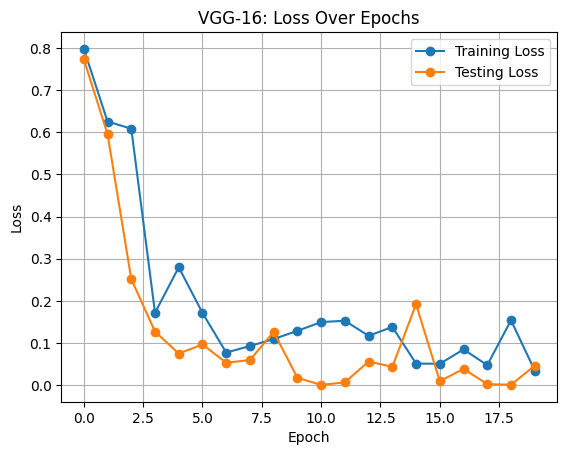

In [ ]:
# Plot the loss
plt.plot(train_losses, marker='o', linestyle='-', label='Training Loss')
plt.plot(test_losses, marker='o', linestyle='-', label='Testing Loss')
plt.title('VGG-16: Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Epoch 0: Train Accuracy: 50.17%, Test Accuracy: 65.83%
Epoch 1: Train Accuracy: 70.91%, Test Accuracy: 80.88%
Epoch 2: Train Accuracy: 81.53%, Test Accuracy: 85.98%
Epoch 3: Train Accuracy: 86.40%, Test Accuracy: 90.02%
Epoch 4: Train Accuracy: 89.46%, Test Accuracy: 93.22%
Epoch 5: Train Accuracy: 90.29%, Test Accuracy: 89.66%
Epoch 6: Train Accuracy: 92.49%, Test Accuracy: 94.15%
Epoch 7: Train Accuracy: 93.99%, Test Accuracy: 92.31%
Epoch 8: Train Accuracy: 93.88%, Test Accuracy: 91.80%
Epoch 9: Train Accuracy: 94.13%, Test Accuracy: 94.96%
Epoch 10: Train Accuracy: 95.24%, Test Accuracy: 94.51%
Epoch 11: Train Accuracy: 95.09%, Test Accuracy: 94.51%
Epoch 12: Train Accuracy: 96.08%, Test Accuracy: 94.61%
Epoch 13: Train Accuracy: 96.33%, Test Accuracy: 95.45%
Epoch 14: Train Accuracy: 95.66%, Test Accuracy: 91.83%
Epoch 15: Train Accuracy: 95.23%, Test Accuracy: 95.19%
Epoch 16: Train Accuracy: 95.57%, Test Accuracy: 94.06%
Epoch 17: Train Accuracy: 95.50%, Test Accuracy: 95.12%
Ep

Text(0.5, 1.0, 'VGG-16: Training and Testing Accuracy Over 20 Epochs')

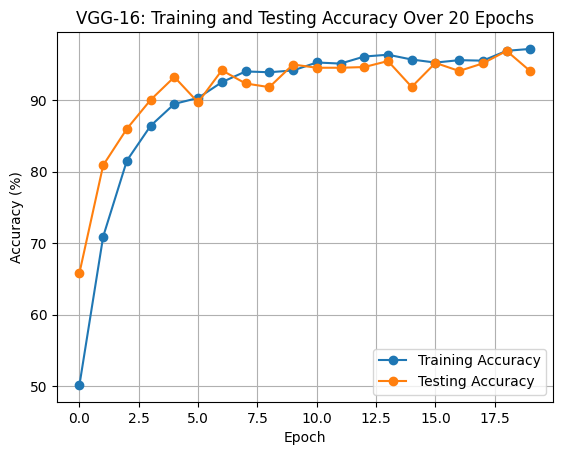

In [ ]:
# Convert tensor to number if necessary, depending on PyTorch version
train_accuracy = [100.0 * correct.item() / len(train_dataset) for correct in train_correct]
test_accuracy = [100.0 * correct.item() / len(test_dataset) for correct in test_correct]

# Display accuracies for each epoch
for epoch, (train_acc, test_acc) in enumerate(zip(train_accuracy, test_accuracy)):
    print(f'Epoch {epoch}: Train Accuracy: {train_acc:.2f}%, Test Accuracy: {test_acc:.2f}%')
# plot the percentages
import matplotlib.pyplot as plt
plt.plot(train_accuracy, marker='o', linestyle='-', label='Training Accuracy')
plt.plot(test_accuracy, marker='o', linestyle='-', label='Testing Accuracy')
# grid
plt.grid(True)
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('VGG-16: Training and Testing Accuracy Over 20 Epochs')

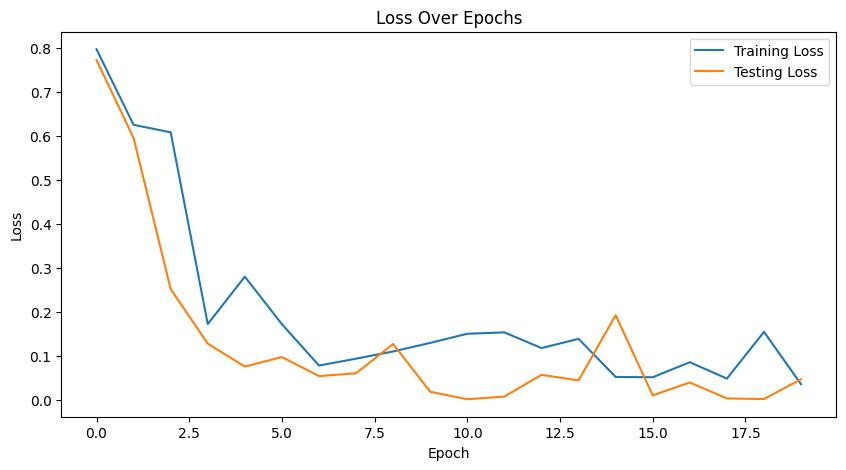

In [ ]:
import matplotlib.pyplot as plt

# Convert losses to scalars if they are tensors
train_losses = [loss.item() for loss in train_losses]
test_losses = [loss.item() for loss in test_losses]

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(range(epochs), train_losses, label='Training Loss')
plt.plot(range(epochs), test_losses, label='Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Over Epochs')
plt.show()


In [ ]:
# Pass all the images in the val_dataset and print them out with actual label and predicted label
vgg_model.eval()  # Set model to evaluation mode

all_preds = []  # Store predicted labels
all_actuals = []  # Store actual labels


vgg_model = vgg_model.to(device)

# Loop through the validation dataset
with torch.no_grad():  # Disable gradient computation
    for data, labels in val_loader:
        # Pass the images through the model
        data, labels = data.to(device), labels.to(device)
        predictions = vgg_model(data)

        # Apply softmax and get the predicted class
        probs = F.softmax(predictions, dim=1)
        predicted_labels = torch.argmax(probs, dim=1)

        # Store predictions and actual labels
        all_preds.extend(predicted_labels.cpu().numpy())
        all_actuals.extend(labels.cpu().numpy())

# Print comparison
for i in range(len(all_preds)):
    print(f"Image {i}: Actual Label = {all_actuals[i]}, Predicted Label = {all_preds[i]}")

Image 0: Actual Label = 1, Predicted Label = 1
Image 1: Actual Label = 1, Predicted Label = 1
Image 2: Actual Label = 2, Predicted Label = 2
Image 3: Actual Label = 3, Predicted Label = 3
Image 4: Actual Label = 1, Predicted Label = 1
Image 5: Actual Label = 3, Predicted Label = 3
Image 6: Actual Label = 1, Predicted Label = 3
Image 7: Actual Label = 0, Predicted Label = 0
Image 8: Actual Label = 4, Predicted Label = 4
Image 9: Actual Label = 0, Predicted Label = 0
Image 10: Actual Label = 2, Predicted Label = 2
Image 11: Actual Label = 3, Predicted Label = 3
Image 12: Actual Label = 1, Predicted Label = 1
Image 13: Actual Label = 1, Predicted Label = 1
Image 14: Actual Label = 1, Predicted Label = 3
Image 15: Actual Label = 0, Predicted Label = 0
Image 16: Actual Label = 1, Predicted Label = 1
Image 17: Actual Label = 2, Predicted Label = 2
Image 18: Actual Label = 1, Predicted Label = 1
Image 19: Actual Label = 1, Predicted Label = 1
Image 20: Actual Label = 1, Predicted Label = 1
Im

In [ ]:
# check accuracy
correct = sum([1 for i in range(len(all_preds)) if all_preds[i] == all_actuals[i]])
print(f"Accuracy: {correct/len(all_preds)}")

Accuracy: 0.9460594315245479


In [ ]:
# Mulitply by 100
print(f"Accuracy: {correct/len(all_preds)*100}%")

Accuracy: 94.60594315245478%


Epoch 0: Train Accuracy: 46.68%, Test Accuracy: 59.53%
Epoch 1: Train Accuracy: 68.64%, Test Accuracy: 79.55%
Epoch 2: Train Accuracy: 80.12%, Test Accuracy: 82.72%
Epoch 3: Train Accuracy: 85.51%, Test Accuracy: 86.89%
Epoch 4: Train Accuracy: 87.68%, Test Accuracy: 85.85%
Epoch 5: Train Accuracy: 90.38%, Test Accuracy: 93.70%
Epoch 6: Train Accuracy: 91.04%, Test Accuracy: 93.18%
Epoch 7: Train Accuracy: 92.34%, Test Accuracy: 93.22%
Epoch 8: Train Accuracy: 94.00%, Test Accuracy: 90.83%
Epoch 9: Train Accuracy: 93.92%, Test Accuracy: 94.44%
Epoch 10: Train Accuracy: 95.05%, Test Accuracy: 92.64%
Epoch 11: Train Accuracy: 95.33%, Test Accuracy: 93.35%
Epoch 12: Train Accuracy: 95.85%, Test Accuracy: 94.51%
Epoch 13: Train Accuracy: 95.52%, Test Accuracy: 95.51%
Epoch 14: Train Accuracy: 96.04%, Test Accuracy: 95.70%
Epoch 15: Train Accuracy: 96.99%, Test Accuracy: 95.32%
Epoch 16: Train Accuracy: 96.82%, Test Accuracy: 94.80%
Epoch 17: Train Accuracy: 96.61%, Test Accuracy: 93.35%
Ep

Text(0.5, 1.0, 'Training and Testing Accuracy Over Epochs')

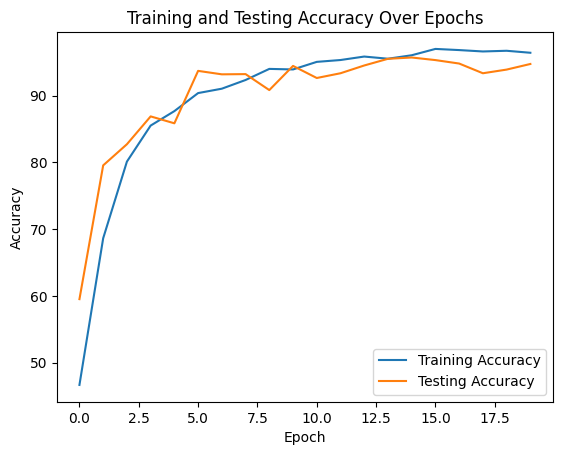

In [ ]:
# Convert tensor to number if necessary, depending on PyTorch version
train_accuracy = [100.0 * correct.item() / len(train_dataset) for correct in train_correct]
test_accuracy = [100.0 * correct.item() / len(test_dataset) for correct in test_correct]

# Display accuracies for each epoch
for epoch, (train_acc, test_acc) in enumerate(zip(train_accuracy, test_accuracy)):
    print(f'Epoch {epoch}: Train Accuracy: {train_acc:.2f}%, Test Accuracy: {test_acc:.2f}%')
# plot the percentages
import matplotlib.pyplot as plt
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(test_accuracy, label='Testing Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Testing Accuracy Over Epochs')

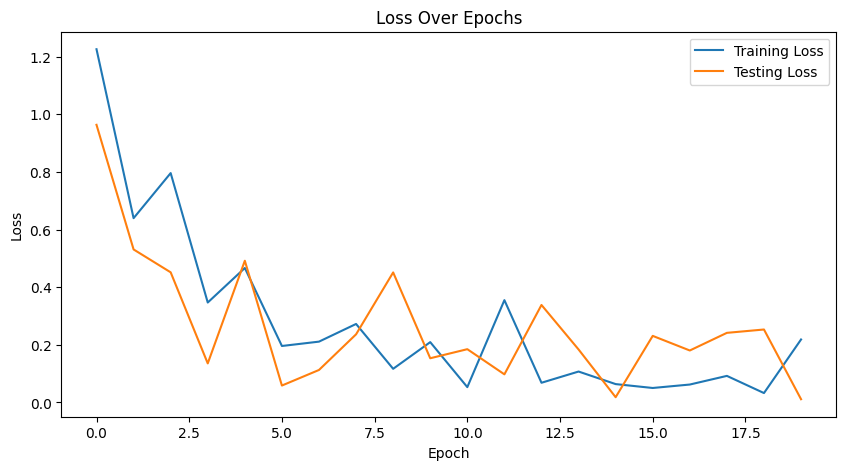

In [ ]:
import matplotlib.pyplot as plt

# Convert losses to scalars if they are tensors
train_losses = [loss for loss in train_losses]
test_losses = [loss for loss in test_losses]

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(range(epochs), train_losses, label='Training Loss')
plt.plot(range(epochs), test_losses, label='Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Over Epochs')
plt.show()


In [ ]:
torch.save(vgg_model.state_dict(), '/content/drive/MyDrive/Dissertation Dataset/vgg_model_20epoch.pth')